In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [9]:
# Reading Data
data_w_wc = pd.read_excel('../raw_data/weekly_data_clean_without_covid.xlsx', engine='openpyxl')
data_d_wc = pd.read_excel('../raw_data/daily_data_clean_without_covid.xlsx', engine='openpyxl')
data_w_co = pd.read_excel('../raw_data/weekly_data_clean_covid_only.xlsx', engine='openpyxl')
data_d_co = pd.read_excel('../raw_data/daily_data_clean_covid_only.xlsx', engine='openpyxl')

In [10]:
# Dropping extra index column
data_w_wc = data_w_wc.drop(columns= 'Unnamed: 0')
data_d_wc = data_d_wc.drop(columns= 'Unnamed: 0')
data_w_co = data_w_co.drop(columns= 'Unnamed: 0')
data_d_co = data_d_co.drop(columns= 'Unnamed: 0')

In [12]:
#Check Nulls
data_w_wc.isnull().sum(), data_d_wc.isnull().sum(), data_w_co.isnull().sum(), data_d_co.isnull().sum()

(date_issue      0
 amount          0
 covid_claims    0
 dtype: int64,
 date_issue      0
 amount          0
 covid_claims    0
 dtype: int64,
 date_issue      0
 amount          0
 covid_claims    0
 dtype: int64,
 date_issue      0
 amount          0
 covid_claims    0
 dtype: int64)

In [13]:
# Check types and lenght
data_w_wc.dtypes, len(data_w_wc), data_d_wc.dtypes, len(data_d_wc)

(date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 132,
 date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 920)

In [14]:
# Check types and lenght
data_w_co.dtypes, len(data_w_co), data_d_co.dtypes, len(data_d_co)

(date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 53,
 date_issue      datetime64[ns]
 amount                   int64
 covid_claims             int64
 dtype: object,
 271)

In [16]:
# Changing index to date
data_d_wc = data_d_wc.set_index('date_issue')
data_w_wc = data_w_wc.set_index('date_issue')
data_d_co = data_d_co.set_index('date_issue')
data_w_co = data_w_co.set_index('date_issue')

<AxesSubplot:xlabel='date_issue'>

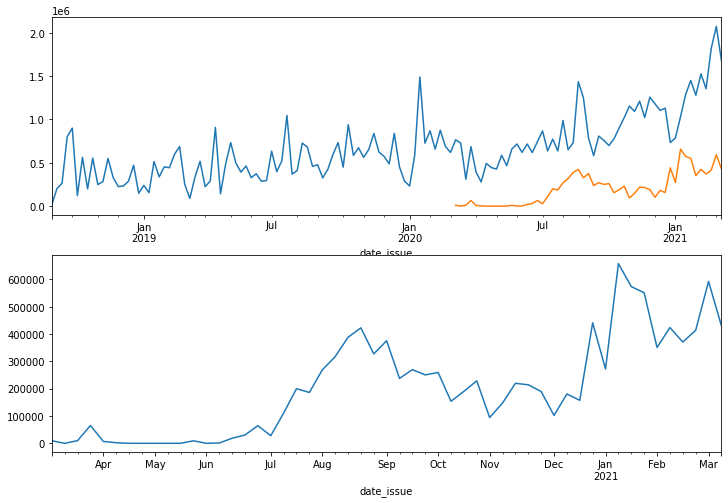

In [22]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
data_w_wc['amount'].plot(ax=ax1)
data_w_co['amount'].plot(ax=ax1)
data_w_co['amount'].plot(ax=ax2)

In [25]:
data_w_wc.drop(columns='covid_claims', inplace=True)


KeyError: "['covid_claims'] not found in axis"

In [26]:
data_w_co.drop(columns='covid_claims', inplace=True)

In [29]:
# Splitting Weekly data 

split = 0.8
split_index_1 = round(len(data_w_wc)*split)
split_index_2 = round(len(data_w_co)*split)
train_wc = data_w_wc.iloc[:split_index_1]
test_wc = data_w_wc.iloc[split_index_1:]
train_co = data_w_co.iloc[:split_index_2]
test_co = data_w_co.iloc[split_index_2:]

### Without Covid

In [30]:
# Autoarima weekly data without Covid

autoarima_wc = pm.auto_arima(train_wc, start_p=0, start_q=0,
                             max_p=3, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1499.240, Time=0.87 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1529.925, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=1.93 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1487.835, Time=1.05 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1498.354, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1483.783, Time=1.59 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1481.784, Time=2.17 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1483.783, Time=3.59 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=1485.783, Time=4.29 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=0.95 sec
 ARIMA(1,1,1)(1,1,0)[52]             : AIC=1483.093, Time=3.03 sec
 ARIMA(0,1,2)(1,1,0)[52]             : AIC=1480.307, Time=4.23 sec
 ARIMA(0,1,2)(0,1,0)[52]             : AIC=1494.564, Time=0.38 sec
 ARIMA(0,1,2)(2,1,0)[52]             : AIC=1482.279, Time=7.62 sec
 ARIMA(0,1,2)(1,1,1)[52]     

In [34]:
# Build model
best_sarima = SARIMAX(train_wc, order=(0, 1, 2),seasonal_order=(1,1,0,52))
best_sarima = best_sarima.fit()

# Forecast
best_results = best_sarima.get_forecast(len(test_wc), alpha=0.05)
best_forecast = best_results.predicted_mean
best_confidence_int = best_results.conf_int()

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [36]:
best_confidence_int

,lower amount,upper amount
2020-09-14,270054.546336,1.571779e+06
2020-09-21,745876.308180,2.130905e+06
2020-09-28,849581.120176,2.242867e+06
2020-10-05,162522.641243,1.564017e+06
2020-10-12,610125.190744,2.019780e+06
2020-10-19,244408.434121,1.662177e+06
2020-10-26,543684.712923,1.969520e+06
2020-11-02,272405.629593,1.706263e+06
2020-11-09,313307.657740,1.755143e+06
2020-11-16,560734.096519,2.010503e+06


In [35]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

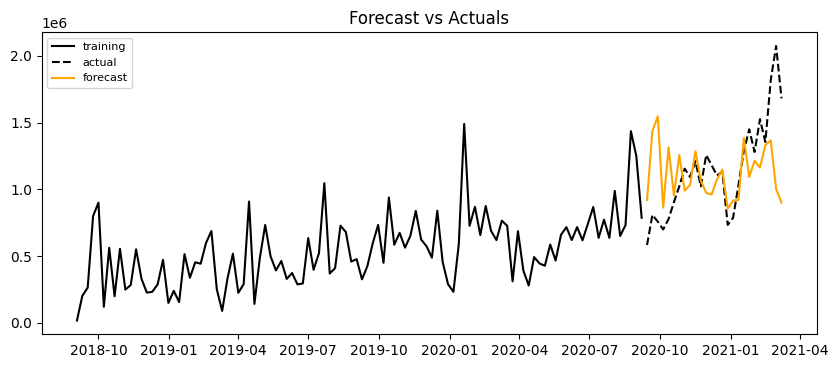

In [37]:
# Plotting 
plot_forecast(best_forecast, train_wc, test_wc, upper = best_confidence_int['upper amount'], lower=best_confidence_int['lower amount'])


In [39]:
# computing mae
best_sarima_performance = pd.DataFrame(test_wc)
best_sarima_performance['forecast'] = best_forecast
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['forecast'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

277241.2109406805

In [41]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['forecast'])

0.2561602201226449

### Trying with detrended serie

In [44]:
# Applying log to train_wc

det_train_wc = np.log(train_wc)

In [45]:
# Autoarima weekly data without Covid detrended

autoarima_wc = pm.auto_arima(det_train_wc, start_p=0, start_q=0,
                             max_p=3, max_q=3, m=52,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore', 
                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=143.183, Time=1.01 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=141.192, Time=0.25 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=137.031, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=120.218, Time=1.37 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=118.656, Time=0.27 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=120.218, Time=1.47 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=122.218, Time=2.24 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=120.656, Time=0.51 sec
 ARIMA(0,1,2)(0,1,0)[52]             : AIC=120.656, Time=0.59 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=135.041, Time=0.15 sec
 ARIMA(1,1,2)(0,1,0)[52]             : AIC=121.292, Time=0.52 sec
 ARIMA(0,1,1)(0,1,0)[52] intercept   : AIC=inf, Time=1.14 sec

Best model:  ARIMA(0,1,1)(0,1,0)[52]          
Total fit time: 10.502 seconds


In [46]:
# Build model
best_sarima = SARIMAX(det_train_wc, order=(0, 1, 1),seasonal_order=(0,1,0,52))
best_sarima = best_sarima.fit()

# Forecast
best_results = best_sarima.get_forecast(len(test_wc), alpha=0.05)
best_forecast = best_results.predicted_mean
best_confidence_int = best_results.conf_int()

/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/santiagochiesa/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


In [52]:
# Reconstructing by applying exp
best_forecast_rec = np.exp(best_forecast)
lower_rec = np.exp(best_confidence_int['lower amount']).values
upper_rec = np.exp(best_confidence_int['upper amount']).values


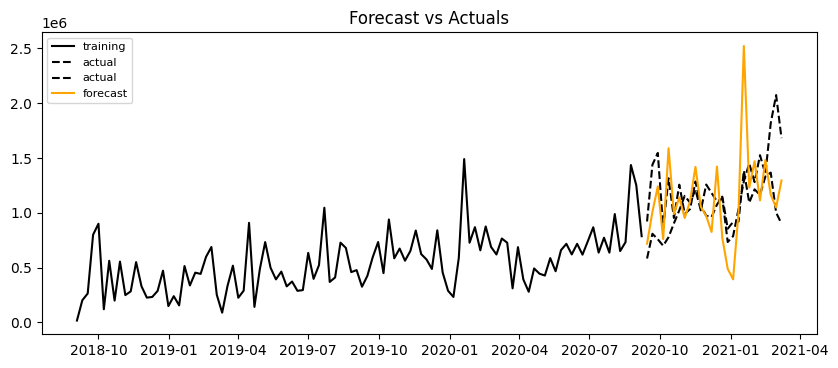

In [53]:
# Plotting 
plot_forecast(best_forecast_rec, train_wc, test_wc)


In [54]:
# computing mae
best_sarima_performance = pd.DataFrame(test_wc)
best_sarima_performance['forecast'] = best_forecast_rec
best_sarima_performance.rename(columns={0: 'amount'}, inplace=True)

best_sarima_performance.dropna(inplace=True)

best_sarima_performance['absolute_error'] = abs(best_sarima_performance['amount'] - best_sarima_performance['forecast'])
best_sarima_performance
best_sarima_performance['absolute_error'].mean()

330521.60489490535

In [55]:
mean_absolute_percentage_error(best_sarima_performance['amount'], best_sarima_performance['forecast'])

0.2907120122456493

In [ ]:
# Applying log gives a worse result

### Covid Only

In [43]:
# Autoarima weekly data Covid only

# autoarima_co = pm.auto_arima(train_co, start_p=0, start_q=0,
#                              max_p=3, max_q=3, m=52,
#                              start_P=0, seasonal=True,
#                              trace=True,
#                              error_action='ignore', 
#                              suppress_warnings=True)


# Throws ValueError: There are no more samples after a first-order seasonal differencing.

### For Friday

In [56]:
# Try to improve model without covid (trying seasonal decompose, etc.)
# Figure out how to predict only covid data since data set is small and has a lot of zeros.